# Data Preprocessing




In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import seaborn as sns

In [ ]:
weather = pd.read_csv("طقس الهند .csv", skiprows=3, header=None)
weather = weather.rename(columns={0: 'time'})

# تسمية أعمدة الطقس
weather_column_names = {
    1: 'temperature_2m_mean (°C)',
    2: 'temperature_2m_max (°C)',
    3: 'temperature_2m_min (°C)',
    4: 'precipitation_sum (mm)',
    5: 'et0_fao_evapotranspiration (mm)',
    6: 'relative_humidity_2m_mean (%)',
    7: 'soil_moisture_0_to_7cm_mean (m³/m³)'
}
weather = weather.rename(columns=weather_column_names)
auction = pd.read_csv("المزاد الهندي .csv")

# توحيد التواريخ
weather['time'] = pd.to_datetime(weather['time'], dayfirst=True)
auction['Date of Auction'] = pd.to_datetime(auction['Date of Auction'], dayfirst=True)

# تنظيف الأرقام
cols_to_clean = ['Avg.Price (Rs./Kg)', 'Total Qty Arrived (Kgs)', 'Qty Sold (Kgs)', 'MaxPrice (Rs./Kg)']
for col in cols_to_clean:
    if auction[col].dtype == 'object':
        auction[col] = auction[col].astype(str).str.replace(",", "").astype(float)

# تجميع المزادات اليومية
daily_auction = auction.groupby('Date of Auction').agg({
    'Avg.Price (Rs./Kg)': 'mean',
    'Total Qty Arrived (Kgs)': 'sum',
    'Qty Sold (Kgs)': 'sum',
    'MaxPrice (Rs./Kg)': 'max',
    'Auctioneer': 'count'
}).reset_index()

daily_auction = daily_auction.rename(columns={'Date of Auction': 'time'})

# دمج البيانات الأساسية
df = pd.merge(daily_auction, weather, on='time', how='inner')
df = df.sort_values('time').reset_index(drop=True)

# (The Critical Fix)

In [ ]:
# 1. إنشاء سجل زمني كامل
full_date_range = pd.date_range(start=df['time'].min(), end=df['time'].max(), freq='D')
df_daily = df.set_index('time').reindex(full_date_range)
df_daily['time'] = df_daily.index

# 2. تعبئة الأسعار المفقودة (Interpolation)
df_daily['Avg.Price (Rs./Kg)'] = df_daily['Avg.Price (Rs./Kg)'].interpolate(method='linear')
df_daily['MaxPrice (Rs./Kg)'] = df_daily['MaxPrice (Rs./Kg)'].interpolate(method='linear')

# 3. تعبئة الطقس والكميات
cols_weather = [
    'temperature_2m_mean (°C)', 'temperature_2m_max (°C)', 'temperature_2m_min (°C)',
    'precipitation_sum (mm)', 'et0_fao_evapotranspiration (mm)', 'relative_humidity_2m_mean (%)',
    'soil_moisture_0_to_7cm_mean (m³/m³)'
]
existing_cols = [c for c in cols_weather if c in df_daily.columns]
df_daily[existing_cols] = df_daily[existing_cols].ffill() # استخدام ffill مباشرة بدلاً من fillna(method)
df_daily = df_daily.fillna(0)

# 4. أزمات السوق واستخراج الميزات الزمنية
df_daily['is_flood_crisis'] = 0
mask_flood = (df_daily['time'] >= '2019-06-01') & (df_daily['time'] <= '2020-02-01')
df_daily.loc[mask_flood, 'is_flood_crisis'] = 1

df_daily['is_lockdown'] = 0
mask_lockdown = (df_daily['time'] >= '2020-03-19') & (df_daily['time'] <= '2020-05-28')
df_daily.loc[mask_lockdown, 'is_lockdown'] = 1

df_daily['year'] = df_daily['time'].dt.year
df_daily['month'] = df_daily['time'].dt.month
df_daily['week_of_year'] = df_daily['time'].dt.isocalendar().week.astype(int)
df_daily['day_of_week'] = df_daily['time'].dt.dayofweek

df = df_daily.reset_index(drop=True)

# (Feature Engineering)

In [8]:
# أ- المؤشرات السعرية والـ Lags
df['Lag1'] = df['Avg.Price (Rs./Kg)'].shift(1)
df['Lag7'] = df['Avg.Price (Rs./Kg)'].shift(7)
df['Lag14'] = df['Avg.Price (Rs./Kg)'].shift(14)
df['Lag30'] = df['Avg.Price (Rs./Kg)'].shift(30)
df['Lag_Qty_Sold_1'] = df['Qty Sold (Kgs)'].shift(1)
df['Lag_Total_Qty_Arrived_1'] = df['Total Qty Arrived (Kgs)'].shift(1)
df['Lag_MaxPrice_1'] = df['MaxPrice (Rs./Kg)'].shift(1)

# ب- المتوسطات المتحركة (Rolling Means)
df['MA7'] = df['Avg.Price (Rs./Kg)'].shift(1).rolling(window=7).mean()
df['MA14'] = df['Avg.Price (Rs./Kg)'].shift(1).rolling(window=14).mean()
df['MA30'] = df['Avg.Price (Rs./Kg)'].shift(1).rolling(window=30).mean()

# ج- الميزات المشتقة والطقس
df['Daily_Spread'] = df['MaxPrice (Rs./Kg)'] - df['Avg.Price (Rs./Kg)']
df['Lag_Spread_1'] = df['Daily_Spread'].shift(1)
df['Temp_Diff'] = df['temperature_2m_max (°C)'] - df['temperature_2m_min (°C)']
df['Precip_7D'] = df['precipitation_sum (mm)'].rolling(window=7).sum()
df['RH_7D'] = df['relative_humidity_2m_mean (%)'].rolling(window=7).mean()

# د- البيانات الذهبية (حالة السوق وتأخير الطقس)
df['is_market_open'] = (df['Total Qty Arrived (Kgs)'] > 0).astype(int)
df['Precip_30D_Sum'] = df['precipitation_sum (mm)'].rolling(window=30).sum()
df['Precip_Lag_60'] = df['precipitation_sum (mm)'].shift(60)
df['Soil_Moisture_Lag_14'] = df['soil_moisture_0_to_7cm_mean (m³/m³)'].shift(14)
df['Smooth_Qty_Arrived'] = df['Total Qty Arrived (Kgs)'].rolling(window=7, min_periods=1).mean()

# حذف الصفوف الفارغة الناتجة عن الـ Lags (أول 60 يوم لضمان وجود Lag60)
df = df.dropna().reset_index(drop=True)

print("✅ تمت إضافة البيانات الذهبية ومعالجة كافة الخصائص بنجاح.")

# إعادة ترتيب الأعمدة كما يفضل المهندسون (اختياري ولكن منظم)
cols_ordered = [
    'time', 'year', 'month', 'week_of_year', 'day_of_week', 'is_market_open',
    'Avg.Price (Rs./Kg)', 'MaxPrice (Rs./Kg)', 'Total Qty Arrived (Kgs)', 'Qty Sold (Kgs)',
    'is_flood_crisis', 'is_lockdown', 'Lag1', 'Lag7', 'MA7', 'MA30', 'Precip_Lag_60', 'Soil_Moisture_Lag_14'
]
# سنبقي جميع الأعمدة ولكن نضع الأهم في البداية
all_cols = cols_ordered + [c for c in df.columns if c not in cols_ordered]
df = df[all_cols]

print("-" * 50)
print(f"✅ Pipeline Completed Successfully.")
print(f"✅ Data processed up to: {df['time'].max().date()}")
print(f"✅ Final Shape: {df.shape}")
print("-" * 50)


print(df.columns.tolist())

✅ المرحلة 1 (التنظيف والدمج) تمت بنجاح.
✅ تمت إضافة البيانات الذهبية ومعالجة كافة الخصائص بنجاح.
--------------------------------------------------
✅ Pipeline Completed Successfully.
✅ Data processed up to: 2026-01-09
✅ Final Shape: (2869, 39)
--------------------------------------------------
['time', 'year', 'month', 'week_of_year', 'day_of_week', 'is_market_open', 'Avg.Price (Rs./Kg)', 'MaxPrice (Rs./Kg)', 'Total Qty Arrived (Kgs)', 'Qty Sold (Kgs)', 'is_flood_crisis', 'is_lockdown', 'Lag1', 'Lag7', 'MA7', 'MA30', 'Precip_Lag_60', 'Soil_Moisture_Lag_14', 'Auctioneer', 'temperature_2m_mean (°C)', 'temperature_2m_max (°C)', 'temperature_2m_min (°C)', 'precipitation_sum (mm)', 'et0_fao_evapotranspiration (mm)', 'relative_humidity_2m_mean (%)', 'soil_moisture_0_to_7cm_mean (m³/m³)', 'Lag14', 'Lag30', 'Lag_Qty_Sold_1', 'Lag_Total_Qty_Arrived_1', 'Lag_MaxPrice_1', 'MA14', 'Daily_Spread', 'Lag_Spread_1', 'Temp_Diff', 'Precip_7D', 'RH_7D', 'Precip_30D_Sum', 'Smooth_Qty_Arrived']


# The Final Engineered Column Order

In [9]:
# تعريف المجموعات المنطقية للترتيب
column_order = [
    # 1. الزمن وحالة السوق (المعرفات الأساسية)
    'time', 'year', 'month', 'week_of_year', 'day_of_week',
    'is_market_open', 'is_flood_crisis', 'is_lockdown',

    # 2. البيانات السعرية والكمية (Target Variables)
    'Avg.Price (Rs./Kg)', 'MaxPrice (Rs./Kg)', 'Daily_Spread',
    'Total Qty Arrived (Kgs)', 'Qty Sold (Kgs)', 'Smooth_Qty_Arrived', 'Auctioneer',

    # 3. بيانات الطقس الحالية (Current Weather)
    'temperature_2m_mean (°C)', 'temperature_2m_max (°C)', 'temperature_2m_min (°C)', 'Temp_Diff',
    'precipitation_sum (mm)', 'relative_humidity_2m_mean (%)', 'soil_moisture_0_to_7cm_mean (m³/m³)',
    'et0_fao_evapotranspiration (mm)', 'Precip_7D', 'RH_7D',

    # 4. مؤشرات الماضي السعرية (Price Lags & MA)
    'Lag1', 'Lag7', 'Lag14', 'Lag30', 'Lag_MaxPrice_1', 'Lag_Spread_1',
    'MA7', 'MA14', 'MA30',

    # 5. مؤشرات الماضي للكميات والطقس (Supply & Weather Lags)
    'Lag_Qty_Sold_1', 'Lag_Total_Qty_Arrived_1',
    'Precip_30D_Sum', 'Precip_Lag_60', 'Soil_Moisture_Lag_14'
]

# إعادة ترتيب الأعمدة في DataFrame
# ملاحظة: نستخدم [column_order] لضمان اختيار الأعمدة الموجودة فقط بالترتيب المحدد
df = df.reindex(columns=column_order)

# التأكد من عدم وجود قيم فارغة بعد إضافة الـ Lags المتقدمة (مثل Lag 60)
df = df.dropna().reset_index(drop=True)

# حفظ الملف النهائي
df.to_csv("India_Cardamom_Final_Ready.csv", index=False)

print("-" * 50)
print(f"✅ تم ترتيب الأعمدة هندسياً (39 عمود).")
print(f"📅 النطاق الزمني النهائي: من {df['time'].min().date()} إلى {df['time'].max().date()}")
print(f"📁 اسم الملف: India_Cardamom_Final_Ready.csv")
print("-" * 50)

# عرض أول 5 صفوف للتأكد من الترتيب
display(df.head())

--------------------------------------------------
✅ تم ترتيب الأعمدة هندسياً (39 عمود).
📅 النطاق الزمني النهائي: من 2018-03-04 إلى 2026-01-09
📁 اسم الملف: India_Cardamom_Final_Ready.csv
--------------------------------------------------


,time,year,month,week_of_year,day_of_week,is_market_open,is_flood_crisis,is_lockdown,Avg.Price (Rs./Kg),MaxPrice (Rs./Kg),...,Lag_MaxPrice_1,Lag_Spread_1,MA7,MA14,MA30,Lag_Qty_Sold_1,Lag_Total_Qty_Arrived_1,Precip_30D_Sum,Precip_Lag_60,Soil_Moisture_Lag_14
0,2018-03-04,2018,3,9,6,0,0,0,954.4475,1246.25,...,1244.50,294.5600,948.683571,964.710536,976.347750,92564.6,96298.9,13.9,0.0,54.0
1,2018-03-05,2018,3,10,0,1,0,0,958.9550,1248.00,...,1246.25,291.8025,947.898929,962.539464,974.495833,0.0,0.0,14.0,0.0,46.0
2,2018-03-06,2018,3,10,1,1,0,0,988.5750,1280.00,...,1248.00,289.0450,949.156786,960.646607,973.185167,40462.4,52452.9,14.0,0.0,46.0
3,2018-03-07,2018,3,10,2,1,0,0,1000.7700,1252.00,...,1280.00,291.4250,954.276071,960.395536,973.347000,117266.9,117266.9,14.1,0.0,36.0
4,2018-03-08,2018,3,10,3,1,0,0,968.1450,1282.00,...,1252.00,251.2300,962.453929,961.384107,974.400500,55796.0,56911.2,14.4,0.0,39.0


# (Exploratory Data Analysis)

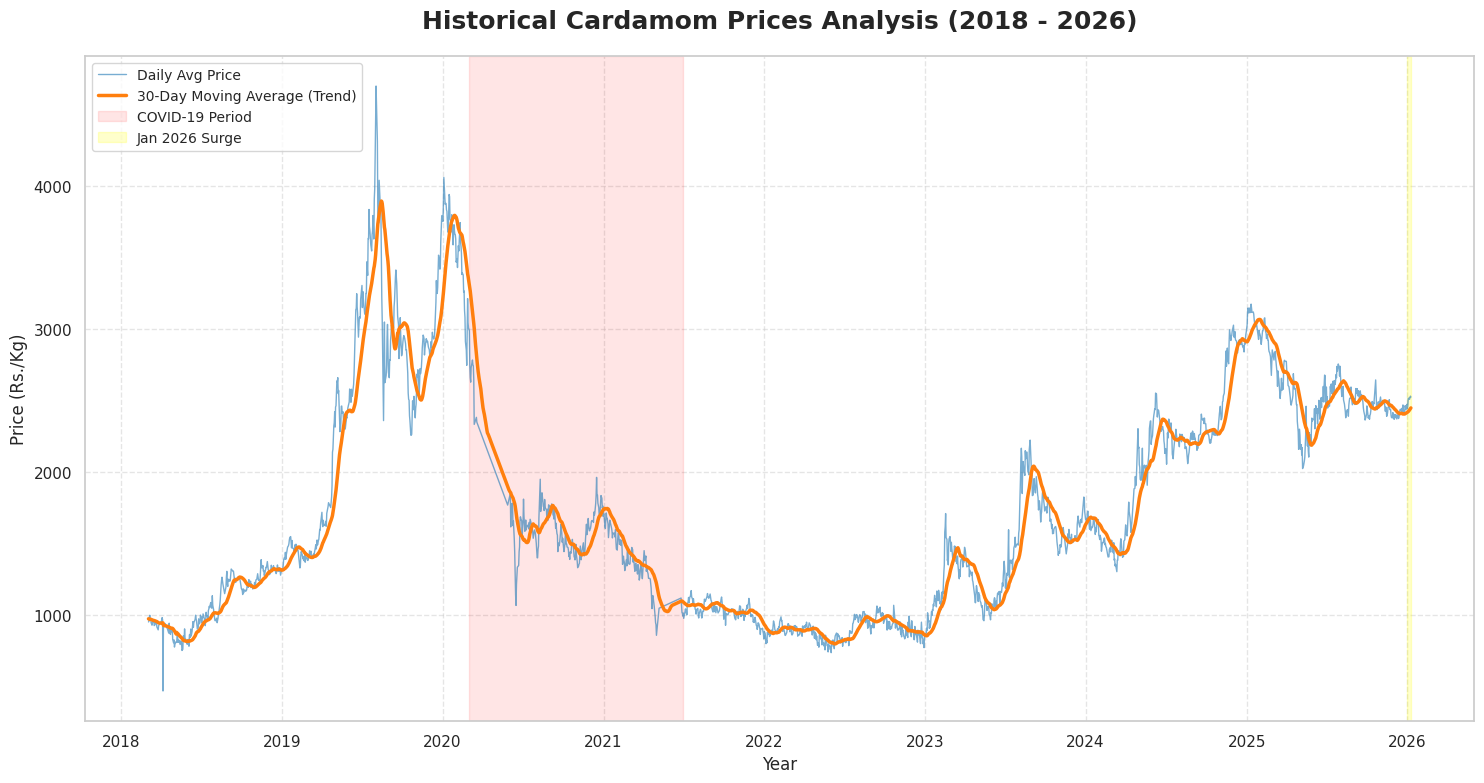

✅ تم إنشاء الرسم البياني بنجاح!
📊 آخر سعر مسجل في البيانات: 2523.47 Rs./Kg


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. تحميل البيانات النهائية (تأكدي من اسم الملف الصحيح لديكِ)
df = pd.read_csv("India_Cardamom_Final_Ready.csv")
df['time'] = pd.to_datetime(df['time'])

# 2. إعداد الشكل العام للرسم
plt.figure(figsize=(15, 8))

# 3. رسم البيانات السعرية اليومية (Daily Avg Price)
plt.plot(df['time'], df['Avg.Price (Rs./Kg)'],
         label='Daily Avg Price',
         color='#1f77b4',
         linewidth=1,
         alpha=0.6)

# 4. رسم المتوسط المتحرك لـ 30 يوماً (Trend)
# ملاحظة: MA30 هو العمود الذي يوضح الاتجاه العام ويخفف حدة التذبذبات
plt.plot(df['time'], df['MA30'],
         label='30-Day Moving Average (Trend)',
         color='#ff7f0e',
         linewidth=2.5)

# 5. تظليل فترة كورونا (COVID Period)
plt.axvspan(pd.to_datetime('2020-03-01'), pd.to_datetime('2021-06-30'),
            color='red',
            alpha=0.1,
            label='COVID-19 Period')

# 6. تظليل قفزة يناير 2026 (Highlight Jan 2026 Jump)
# لإبراز الارتفاع الأخير الذي وصل لـ 3337 روبية
plt.axvspan(pd.to_datetime('2026-01-01'), df['time'].max(),
            color='yellow',
            alpha=0.2,
            label='Jan 2026 Surge')

# 7. إضافة العناوين والتفاصيل الجمالية
plt.title('Historical Cardamom Prices Analysis (2018 - 2026)', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Price (Rs./Kg)', fontsize=12)
plt.legend(loc='upper left', fontsize=10, frameon=True)
plt.grid(True, linestyle='--', alpha=0.5)

# تحسين مظهر المحاور
plt.tight_layout()

# 8. عرض الرسم وحفظه
plt.savefig('Cardamom_Market_Analysis_2026.png', dpi=300)
plt.show()

print(f"✅ تم إنشاء الرسم البياني بنجاح!")
print(f"📊 آخر سعر مسجل في البيانات: {df['Avg.Price (Rs./Kg)'].iloc[-1]:.2f} Rs./Kg")

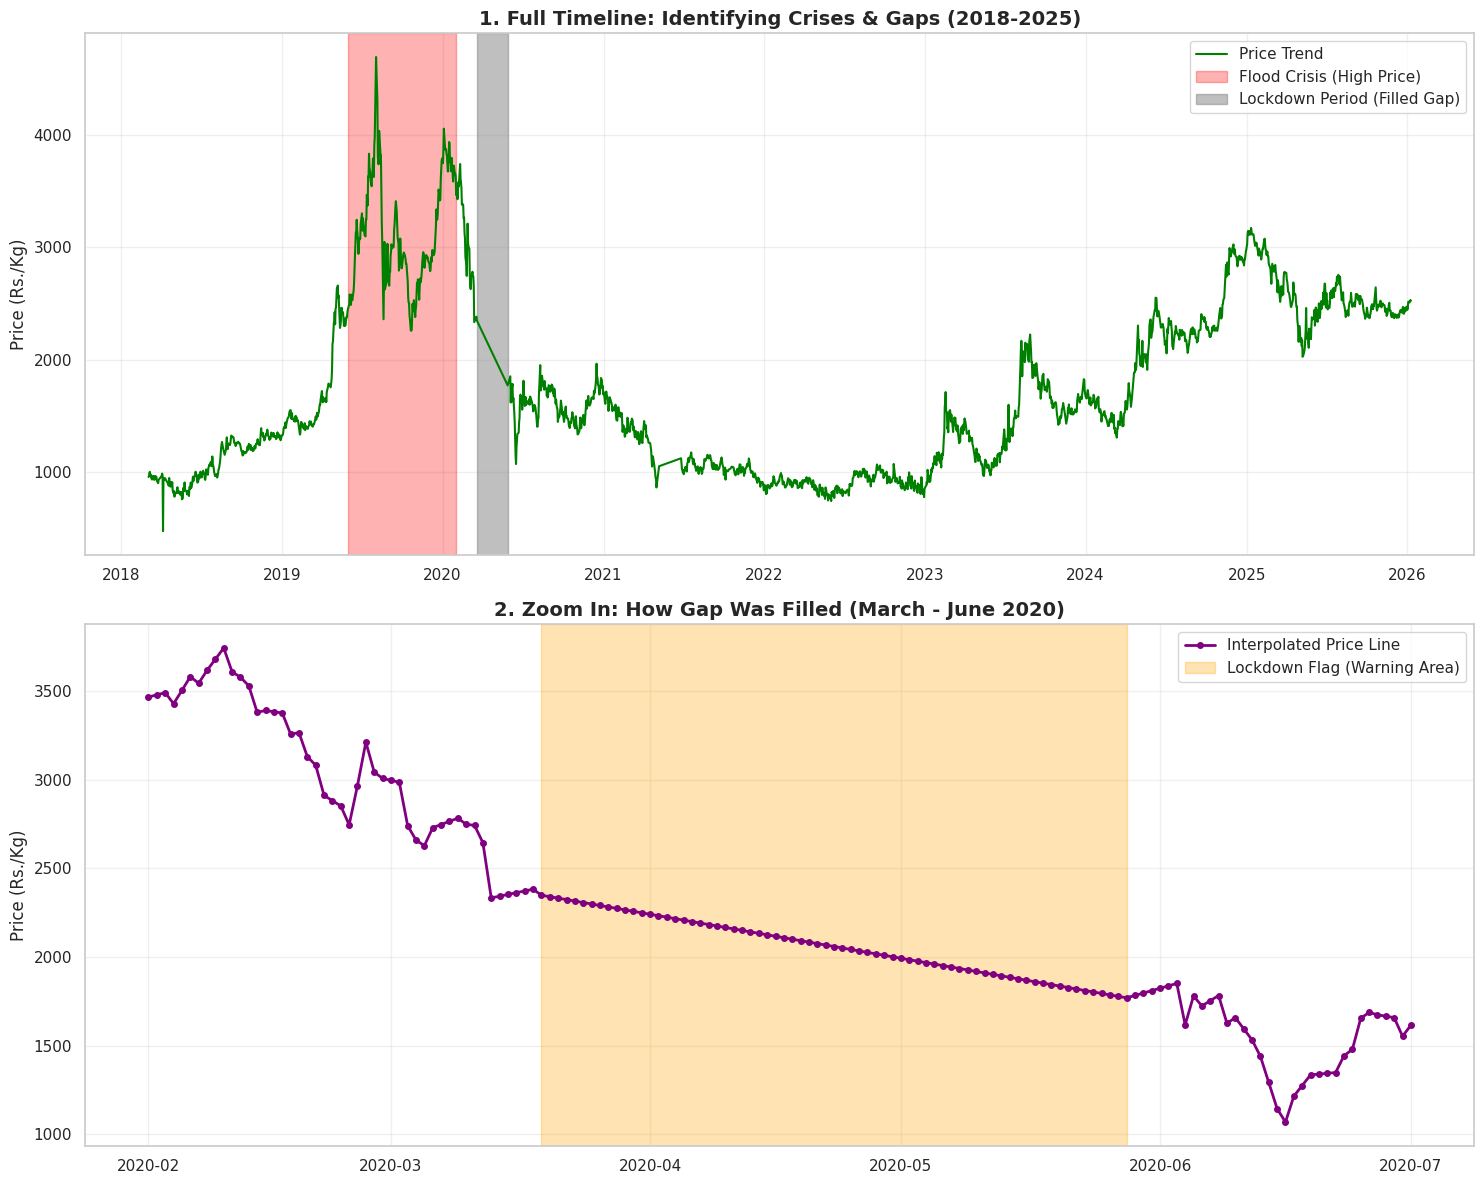

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. تحميل البيانات الجاهزة
df = pd.read_csv('India_Cardamom_Final_Ready.csv')
df['time'] = pd.to_datetime(df['time']) # تحويل عمود الزمن لتنسيق تاريخ

# إعداد حجم الصورة (لوحتين فوق بعض)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12)) # حجم كبير وواضح

# =========================================================
# 📊 الرسمة الأولى (العلوية): النظرة الشاملة لكل السنوات
# =========================================================
# رسم خط السعر باللون الأخضر
ax1.plot(df['time'], df['Avg.Price (Rs./Kg)'], color='green', linewidth=1.5, label='Price Trend')

# 🔴 تظليل منطقة "جنون الأسعار" (الفيضانات) باللون الأحمر
flood_data = df[df['is_flood_crisis'] == 1]
if not flood_data.empty:
    ax1.axvspan(flood_data['time'].min(), flood_data['time'].max(),
                color='red', alpha=0.3, label='Flood Crisis (High Price)')

# ⚪ تظليل منطقة "إغلاق كورونا" باللون الرمادي
lockdown_data = df[df['is_lockdown'] == 1]
if not lockdown_data.empty:
    ax1.axvspan(lockdown_data['time'].min(), lockdown_data['time'].max(),
                color='grey', alpha=0.5, label='Lockdown Period (Filled Gap)')

# تنسيقات الرسمة الأولى
ax1.set_title('1. Full Timeline: Identifying Crises & Gaps (2018-2025)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Price (Rs./Kg)')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)


# =========================================================
# 🔍 الرسمة الثانية (السفلية): التكبير (Zoom In) على فترة الإغلاق
# =========================================================
# تحديد فترة التكبير (من فبراير 2020 إلى يوليو 2020)
zoom_start = '2020-02-01'
zoom_end = '2020-07-01'
mask_zoom = (df['time'] >= zoom_start) & (df['time'] <= zoom_end)
df_zoom = df.loc[mask_zoom]

# 🟣 رسم الخط المتصل (Interpolated) باللون البنفسجي مع نقاط
ax2.plot(df_zoom['time'], df_zoom['Avg.Price (Rs./Kg)'], 'o-', color='purple', markersize=4, linewidth=2, label='Interpolated Price Line')

# 🟠 تظليل منطقة الإغلاق باللون البرتقالي (الذي يعلم الموديل أنها تقديرية)
zoom_lockdown = df_zoom[df_zoom['is_lockdown'] == 1]
if not zoom_lockdown.empty:
    ax2.axvspan(zoom_lockdown['time'].min(), zoom_lockdown['time'].max(),
                color='orange', alpha=0.3, label='Lockdown Flag (Warning Area)')

# تنسيقات الرسمة الثانية
ax2.set_title('2. Zoom In: How Gap Was Filled (March - June 2020)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Price (Rs./Kg)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# عرض الرسم النهائي
plt.tight_layout()
plt.show()

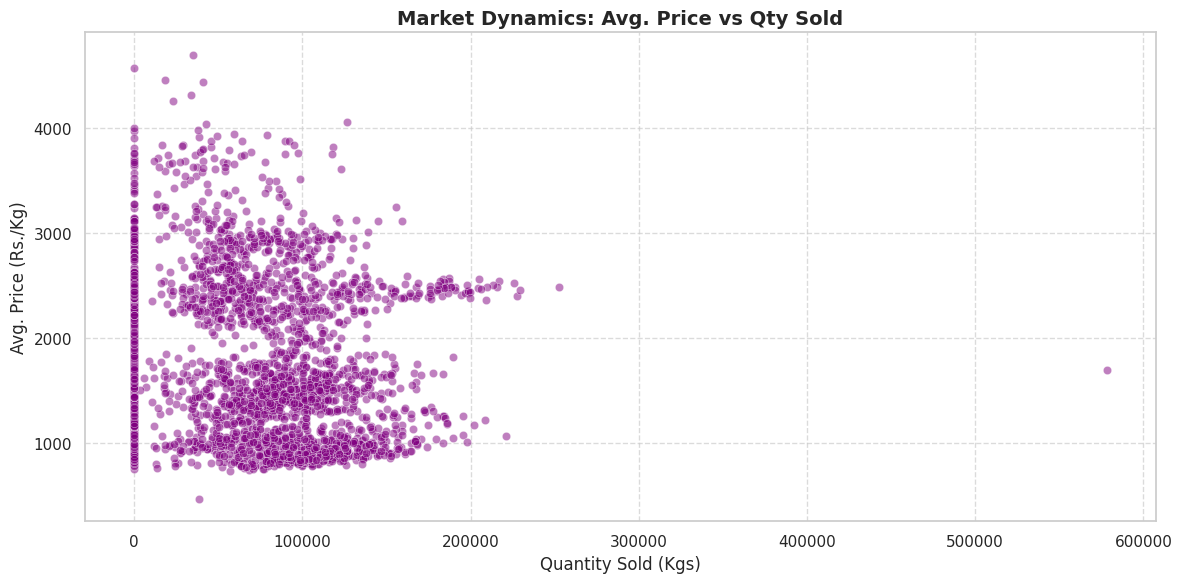

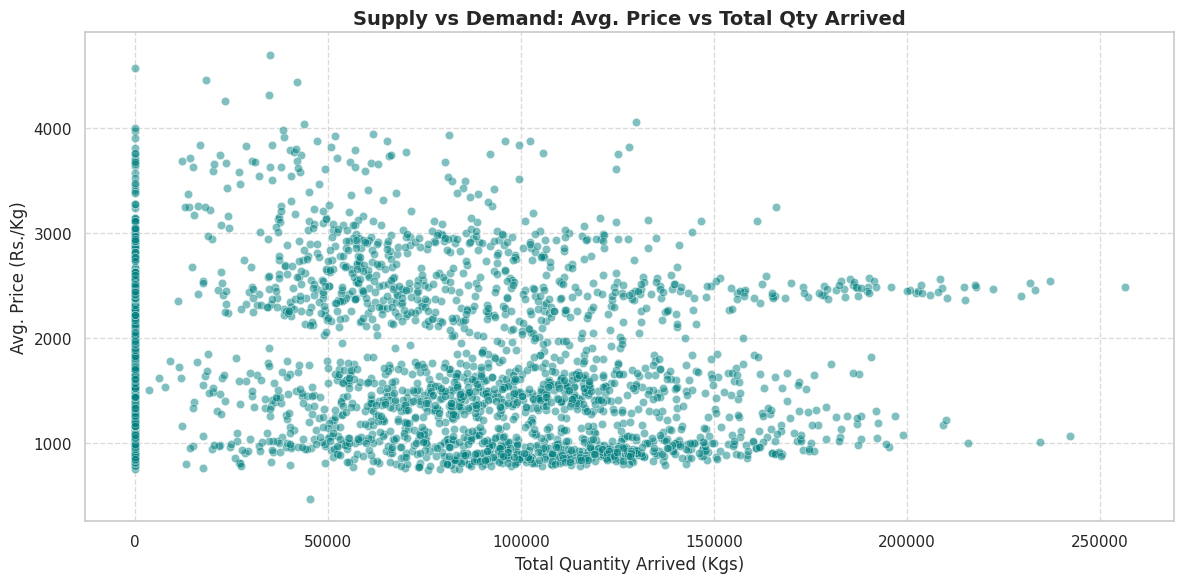

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# ضبط الستايل العام للرسوم (المظهر النظيف)
sns.set_style("whitegrid")

# ==========================================
# 1. Scatter Plot: Price vs Quantity Sold
# (تحليل فاعلية الشراء: هل السعر يتأثر بما يتم بيعه فعلياً؟)
# ==========================================
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Qty Sold (Kgs)',
                y='Avg.Price (Rs./Kg)',
                data=df,
                alpha=0.5,           # شفافية النقاط لرؤية الكثافة
                color='purple',      # اللون الأرجواني الذي طلبته
                edgecolor='w')       # حدود بيضاء للنقاط لتمييزها

plt.title('Market Dynamics: Avg. Price vs Qty Sold', fontsize=14, fontweight='bold')
plt.xlabel('Quantity Sold (Kgs)', fontsize=12)
plt.ylabel('Avg. Price (Rs./Kg)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# ==========================================
# 2. Scatter Plot: Price vs Total Arrival
# (قانون العرض والطلب: السعر مقابل الكمية الواصلة للسوق)
# ==========================================
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Total Qty Arrived (Kgs)',
                y='Avg.Price (Rs./Kg)',
                data=df,
                alpha=0.5,
                color='teal',        # اللون النيلي الذي طلبته
                edgecolor='w')

plt.title('Supply vs Demand: Avg. Price vs Total Qty Arrived', fontsize=14, fontweight='bold')
plt.xlabel('Total Quantity Arrived (Kgs)', fontsize=12)
plt.ylabel('Avg. Price (Rs./Kg)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

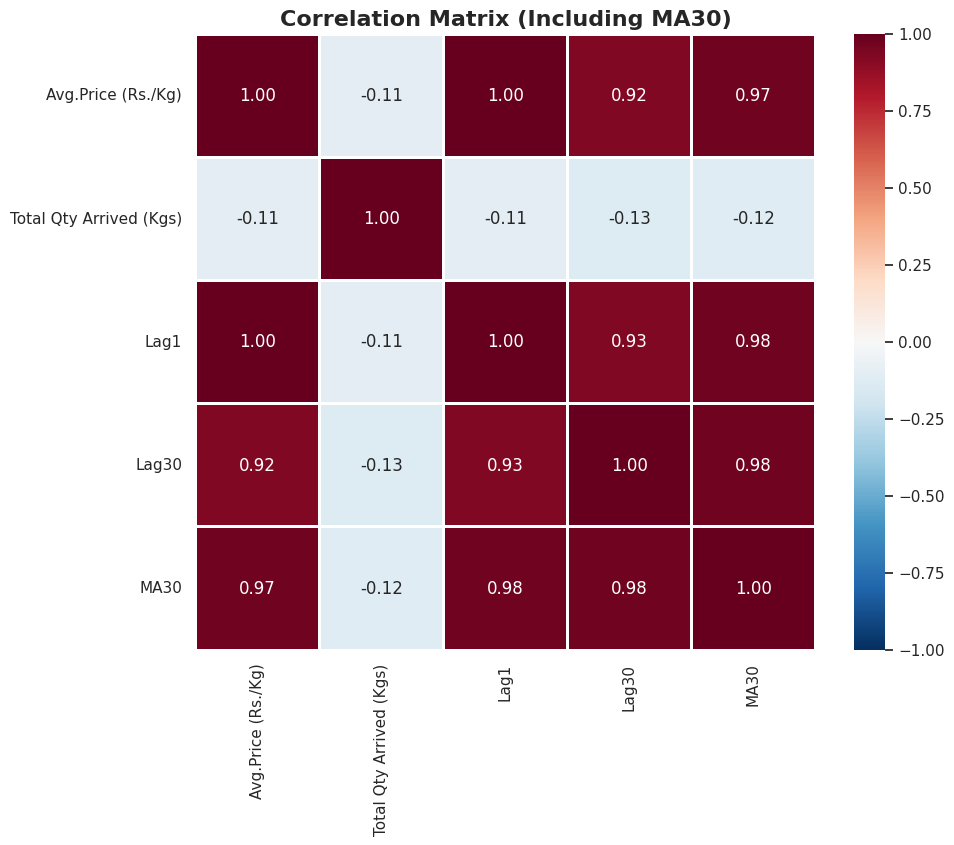

In [22]:
cols_to_check = [
    'Avg.Price (Rs./Kg)',
    'Total Qty Arrived (Kgs)',
    'Lag1',
    'Lag30',
    'MA30'  # <--- ضفناها هنا عشان خاطرك
]

plt.figure(figsize=(10, 8))
corr_matrix = df[cols_to_check].corr()

# رسم الخريطة
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', fmt=".2f", linewidths=1, vmin=-1, vmax=1)
plt.title('Correlation Matrix (Including MA30)', fontsize=16, fontweight='bold')
plt.show()

/tmp/ipython-input-2641067068.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='month', y='Avg.Price (Rs./Kg)', data=df, palette="viridis")


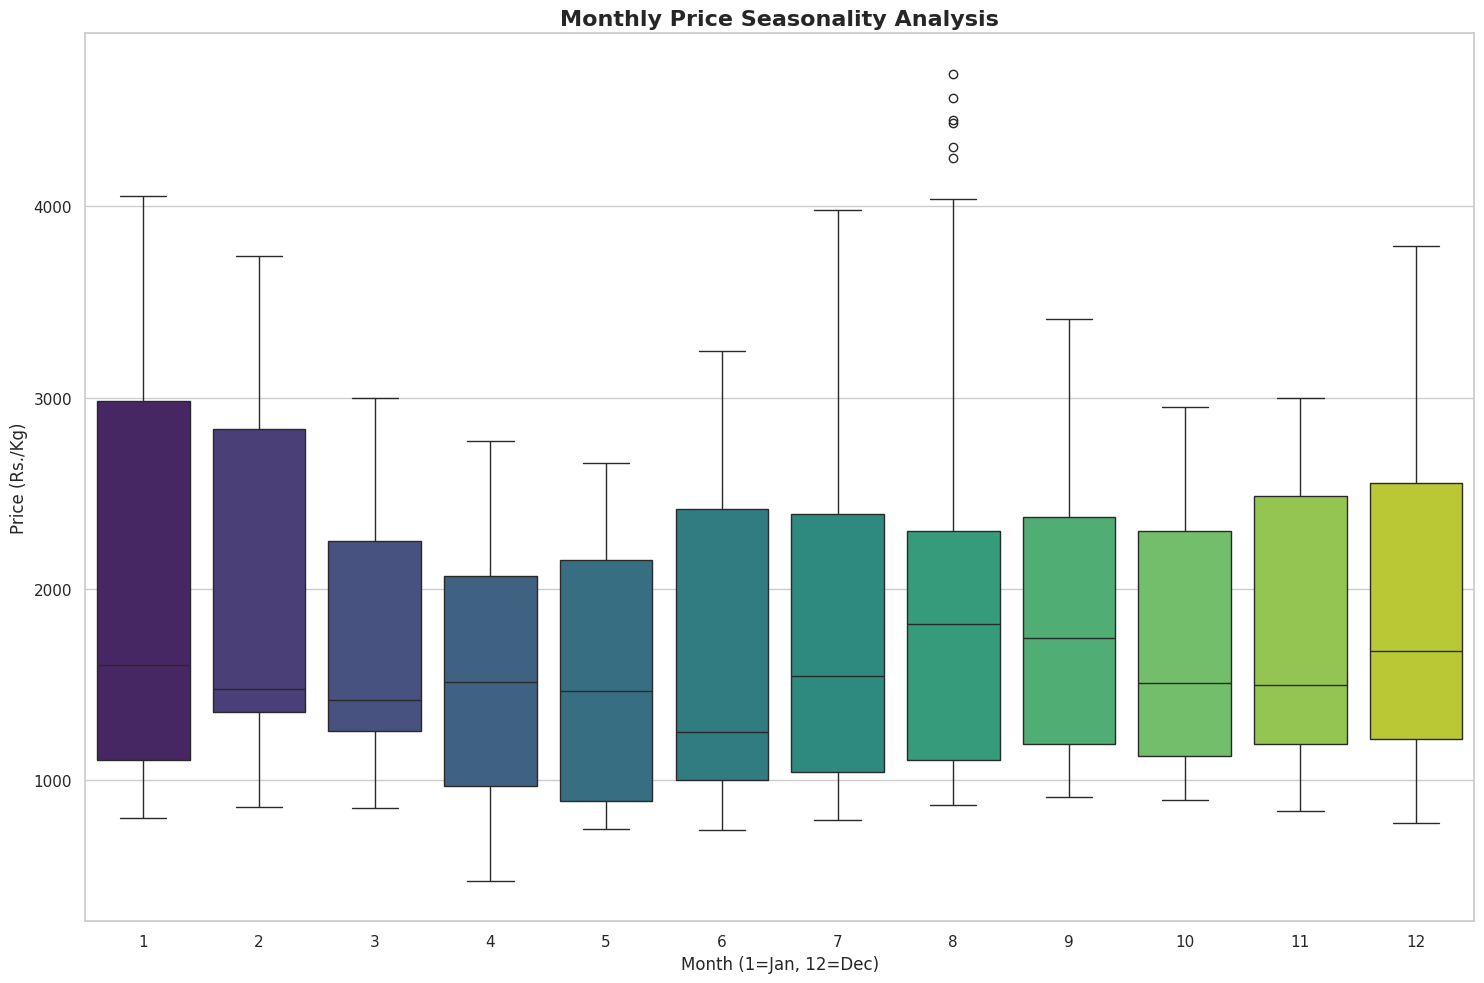

In [23]:
plt.figure()
sns.boxplot(x='month', y='Avg.Price (Rs./Kg)', data=df, palette="viridis")

plt.title('Monthly Price Seasonality Analysis', fontsize=16, fontweight='bold')
plt.xlabel('Month (1=Jan, 12=Dec)')
plt.ylabel('Price (Rs./Kg)')
plt.tight_layout()
plt.show()

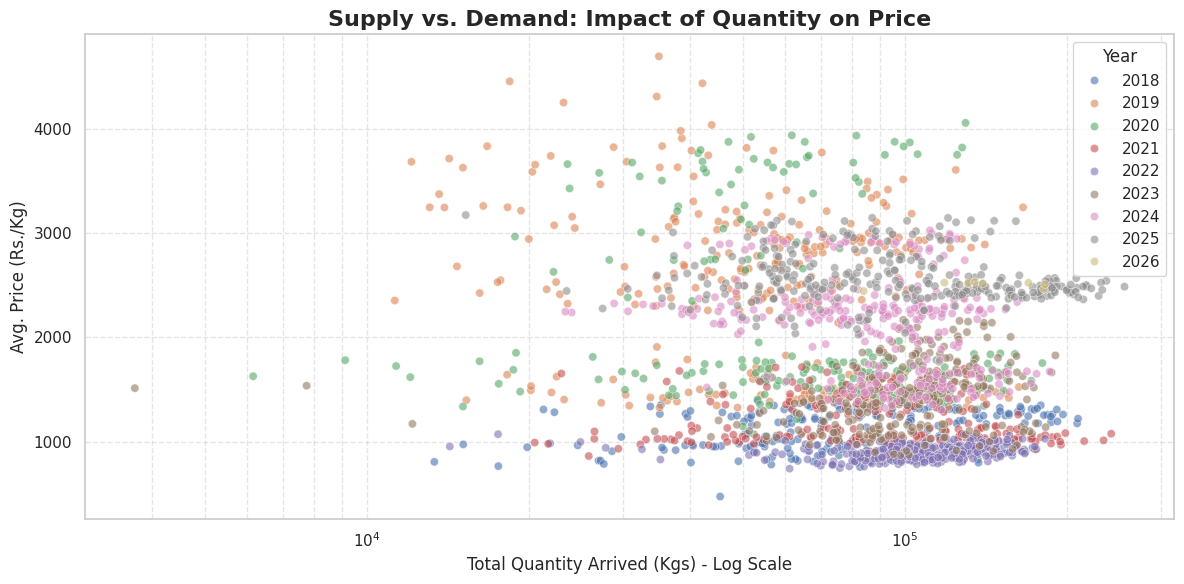

In [15]:

plt.figure(figsize=(12, 6))
sns.scatterplot(x='Total Qty Arrived (Kgs)', y='Avg.Price (Rs./Kg)', data=df, hue='year', palette='deep', alpha=0.6)

plt.title('Supply vs. Demand: Impact of Quantity on Price', fontsize=16, fontweight='bold')
plt.xlabel('Total Quantity Arrived (Kgs) - Log Scale')
plt.ylabel('Avg. Price (Rs./Kg)')
plt.xscale('log') # Log scale for better visibility
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.legend(title='Year')
plt.tight_layout()
plt.show()

/tmp/ipython-input-313957084.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = df.resample('M', on='time')['Avg.Price (Rs./Kg)'].mean().reset_index()


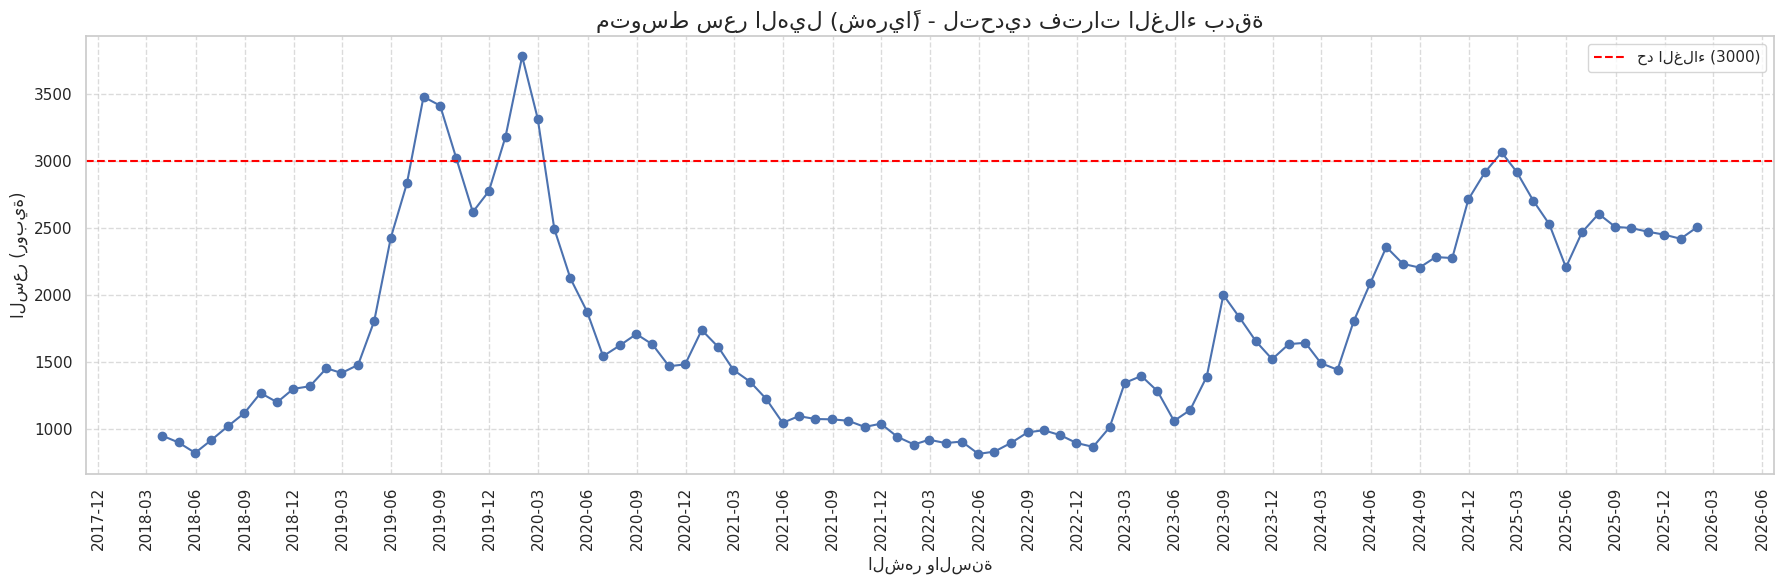


🚨 الأشهر التي تجاوز فيها السعر 3000 روبية (فترة الجنون):
📅 2019-07 : السعر 3476
📅 2019-08 : السعر 3410
📅 2019-09 : السعر 3019
📅 2019-12 : السعر 3179
📅 2020-01 : السعر 3778
📅 2020-02 : السعر 3314
📅 2025-01 : السعر 3062


In [17]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# 1. تجميع البيانات شهرياً (عشان الرسمة تكون واضحة وما فيها شوشرة)
monthly_data = df.resample('M', on='time')['Avg.Price (Rs./Kg)'].mean().reset_index()

# 2. إعداد الرسمة
plt.figure(figsize=(18, 6)) # عرضنا الرسمة عشان تشوف كل شهر بوضوح
plt.plot(monthly_data['time'], monthly_data['Avg.Price (Rs./Kg)'], marker='o', linestyle='-')

# 3. إعداد محور الوقت ليعرض كل 3 أشهر
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.title('متوسط سعر الهيل (شهرياً) - لتحديد فترات الغلاء بدقة', fontsize=16)
plt.xlabel('الشهر والسنة')
plt.ylabel('السعر (روبية)')
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.xticks(rotation=90) # تدوير التاريخ عشان ينقرا
plt.tight_layout()

# رسم خط أحمر عند سعر 3000 (حد الغلاء الفاحش)
plt.axhline(y=3000, color='red', linestyle='--', label='حد الغلاء (3000)')
plt.legend()
plt.show()

# ========================================================
# طباعة التواريخ المشبوهة (اللي السعر فيها فوق 3000)
# ========================================================
print("\n🚨 الأشهر التي تجاوز فيها السعر 3000 روبية (فترة الجنون):")
high_price_months = monthly_data[monthly_data['Avg.Price (Rs./Kg)'] > 3000]

for index, row in high_price_months.iterrows():
    # طباعة التاريخ بصيغة: السنة-الشهر -> السعر
    print(f"📅 {row['time'].strftime('%Y-%m')} : السعر {row['Avg.Price (Rs./Kg)']:.0f}")

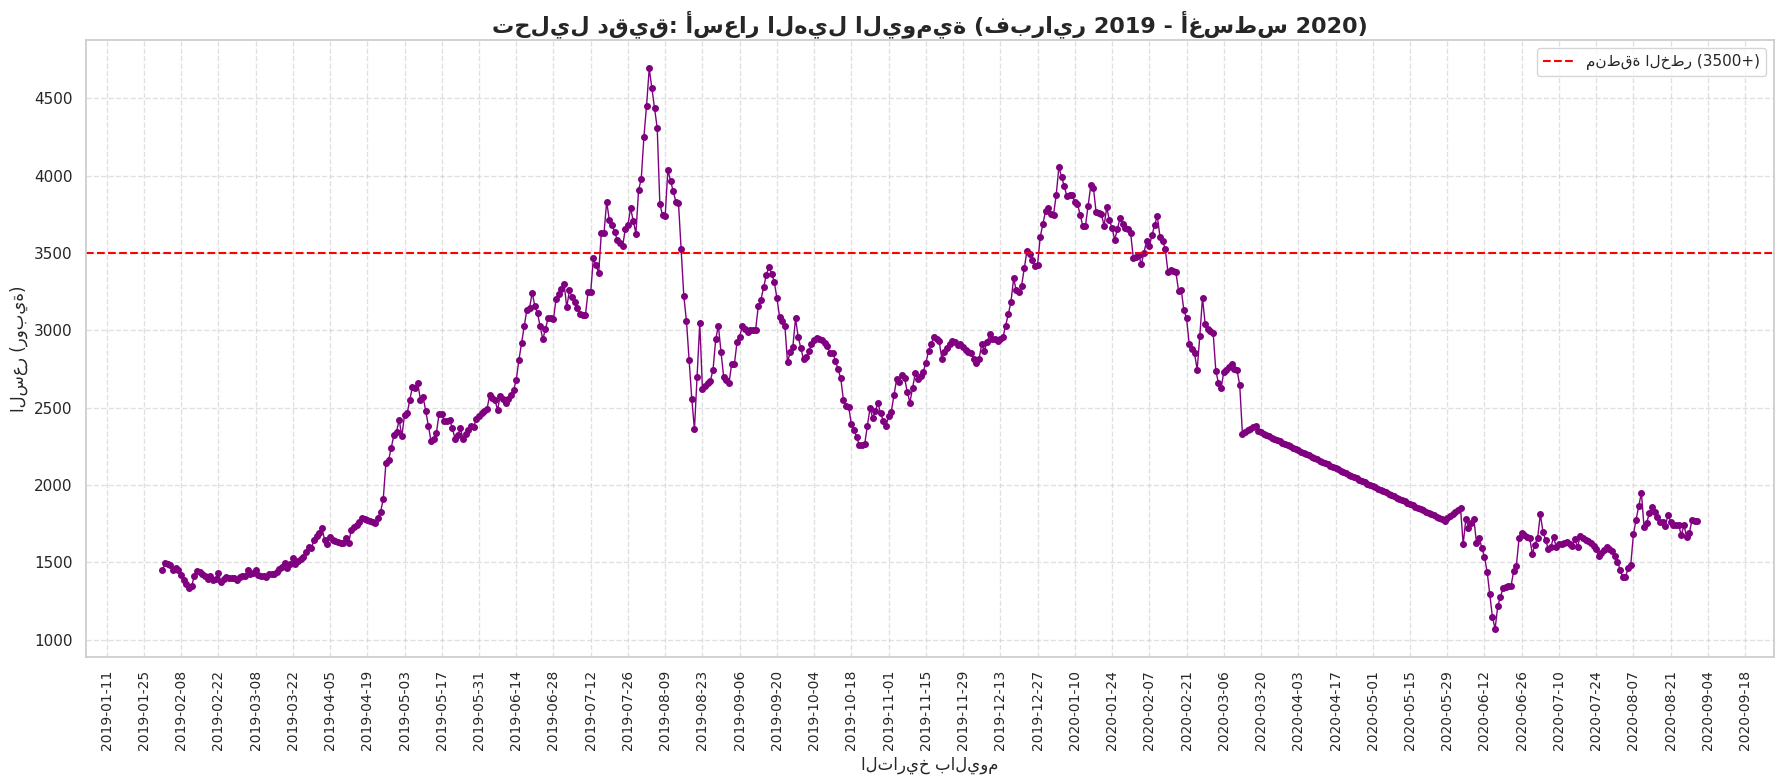


🕵️‍♂️ تقرير التواريخ الدقيقة:
🔥 أعلى سعر (القمة) وصل له السوق: 4694.17 روبية بتاريخ: 2019-08-03
لم يتم اكتشاف انقطاع طويل في هذه الفترة.


In [18]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# 1. تحديد الفترة المطلوبة (من شهر 2-2019 إلى 8-2020)
start_date = '2019-02-01'
end_date = '2020-08-31'

# فلترة البيانات لهذه الفترة فقط
zoom_df = df[(df['time'] >= start_date) & (df['time'] <= end_date)].copy()
zoom_df = zoom_df.sort_values('time') # ترتيب مهم جداً

# 2. إعداد الرسمة التفصيلية
plt.figure(figsize=(18, 8)) # حجم كبير وواضح

# رسم النقاط والخطوط
plt.plot(zoom_df['time'], zoom_df['Avg.Price (Rs./Kg)'],
         marker='o',       # وضع دائرة صغيرة لكل يوم مزاد
         markersize=4,
         linestyle='-',    # خط يوصل بينهم
         linewidth=1,
         color='purple')

# 3. إعداد محور الوقت ليكون دقيقاً (كل أسبوعين)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=14)) # كل 14 يوم يكتب التاريخ
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) # الصيغة: سنة-شهر-يوم
plt.xticks(rotation=90, fontsize=10) # تدوير النص ليكون مقروءاً

plt.title('تحليل دقيق: أسعار الهيل اليومية (فبراير 2019 - أغسطس 2020)', fontsize=16, fontweight='bold')
plt.xlabel('التاريخ باليوم')
plt.ylabel('السعر (روبية)')
plt.grid(True, which='both', linestyle='--', alpha=0.6)

# تظليل فترة القمة (مثلاً فوق 3500)
plt.axhline(y=3500, color='red', linestyle='--', label='منطقة الخطر (3500+)')
plt.legend()
plt.tight_layout()
plt.show()

# ========================================================
# 4. المحقق الذكي: استخراج التواريخ المهمة برمجياً
# ========================================================
print("\n🕵️‍♂️ تقرير التواريخ الدقيقة:")

# أ) متى كانت أعلى قمة بالضبط؟
max_price = zoom_df['Avg.Price (Rs./Kg)'].max()
peak_date = zoom_df.loc[zoom_df['Avg.Price (Rs./Kg)'] == max_price, 'time'].iloc[0]
print(f"🔥 أعلى سعر (القمة) وصل له السوق: {max_price} روبية بتاريخ: {peak_date.strftime('%Y-%m-%d')}")

# ب) كشف فجوة كورونا (متى انقطعت البيانات؟)
# نحسب الفرق بالأيام بين كل مزاد والمزاد اللي بعده
zoom_df['diff_days'] = zoom_df['time'].diff().dt.days
# نعتبر أي انقطاع أكثر من 20 يوم هو "توقف السوق"
gap_period = zoom_df[zoom_df['diff_days'] > 20]

if not gap_period.empty:
    for index, row in gap_period.iterrows():
        # التاريخ الحالي هو تاريخ "العودة"
        end_gap = row['time']
        # التاريخ السابق له هو تاريخ "التوقف"
        start_gap_idx = zoom_df.index.get_loc(index) - 1
        start_gap = zoom_df.iloc[start_gap_idx]['time']

        print(f"⛔ انقطاع السوق (كورونا):")
        print(f"   - آخر مزاد قبل الإغلاق: {start_gap.strftime('%Y-%m-%d')}")
        print(f"   - أول مزاد بعد العودة:  {end_gap.strftime('%Y-%m-%d')}")
        print(f"   - مدة التوقف: {row['diff_days']:.0f} يوماً")
else:
    print("لم يتم اكتشاف انقطاع طويل في هذه الفترة.")